<a href="https://colab.research.google.com/github/albertomariapepe/Learning-Rotations/blob/main/Point_Clouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Point Clouds from ModelNet10

In [ ]:
import numpy as np
import random
import math
!pip install path.py;
from path import Path

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip

path = Path("ModelNet10")

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

with open(path/"toilet/train/toilet_0002.off", 'r') as f:
    mesh = read_off(f)

verts, faces = mesh
areas = np.zeros((len(faces)))
verts = np.array(verts)

# function to calculate triangle area by its vertices
# https://en.wikipedia.org/wiki/Heron%27s_formula
def triangle_area(pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * ( side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

# we calculate areas of all faces in our mesh
for i in range(len(areas)):
    areas[i] = (triangle_area(verts[faces[i][0]],
                              verts[faces[i][1]],
                              verts[faces[i][2]]))

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8), dpi= 100)
ax = plt.axes(projection='3d')

#for i in range(0, int(len(verts)/3)):
ax.scatter3D(verts[:,0], verts[:,1], verts[:,2], c=verts[:,2], cmap='rainbow');

plt.figure()

In [ ]:
k = 3000
# we sample 'k' faces with probabilities proportional to their areas
# weights are used to create a distribution.
# they don't have to sum up to one.
sampled_faces = (random.choices(faces, 
                                weights=areas,
                                k=k))

# function to sample points on a triangle surface
def sample_point(pt1, pt2, pt3):
    # barycentric coordinates on a triangle
    # https://mathworld.wolfram.com/BarycentricCoordinates.html
    s, t = sorted([random.random(), random.random()])
    f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
    return (f(0), f(1), f(2))
 
pointcloud = np.zeros((k, 3))

# sample points on chosen faces for the point cloud of size 'k'
for i in range(len(sampled_faces)):
    pointcloud[i] = (sample_point(verts[sampled_faces[i][0]],
                                  verts[sampled_faces[i][1]],
                                  verts[sampled_faces[i][2]]))

In [ ]:
fig = plt.figure(figsize=(8,12), dpi= 100)
ax = plt.axes(projection='3d')

#for i in range(0, int(len(verts)/3)):
ax.scatter3D(pointcloud[:,0], pointcloud[:,1], pointcloud[:,2], c=pointcloud[:,2], cmap='rainbow');

plt.figure()

In [ ]:
# normalize
norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
noisy_pointcloud = norm_pointcloud
'''
# rotation around z-axis
theta = random.random() * 2. * math.pi # rotation angle
rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                       [ math.sin(theta),  math.cos(theta),    0],
                       [0,                             0,      1]])

rot_pointcloud = rot_matrix.dot(pointcloud.T).T

# add some noise
noise = np.random.normal(0, 0.02, (pointcloud.shape))
noisy_pointcloud = rot_pointcloud + noise

'''
fig = plt.figure(figsize=(8,12), dpi= 100)
ax = plt.axes(projection='3d')

#for i in range(0, int(len(verts)/3)):
ax.scatter3D(noisy_pointcloud[:,0], noisy_pointcloud[:,1], noisy_pointcloud[:,2], c=noisy_pointcloud[:,2], cmap='rainbow');

plt.figure()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                #ToTensor()
                              ])
    

class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}


train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize()
                    ])

train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [ ]:
#SAMPLING BUT FOR THE AIRPLANE POINT CLOUDS ONLY.

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os

from google.colab import drive
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/AIRPLANE/')

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

def default_transforms():
    return transforms.Compose([
                                PointSampler(3000),
                                Normalize(),
                                #ToTensor()
                              ])
    

class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}


train_transforms = transforms.Compose([
                    PointSampler(3000),
                    Normalize()
                    ])

train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

#print(train_ds[i])

In [ ]:
train_PC = []
test_PC = []
for i in range(0, len(train_ds)):
    train_PC = np.append(train_PC, train_ds[i]['pointcloud'])
    print(i, '/', len(train_ds))

In [ ]:
test_PC = []
for i in range(0, len(valid_ds)):
    test_PC = np.append(test_PC, valid_ds[i]['pointcloud'])
    print(i, '/', len(valid_ds))

In [ ]:
size = 3000

print(np.shape(train_PC))
train_PC = np.reshape(train_PC, [626, size, 3])
np.shape(train_PC)

test_PC = np.reshape(test_PC, [100, size, 3])
np.shape(test_PC)

print(np.shape(train_PC))
print(np.shape(test_PC))

np.save('train_point_cloud.npy', train_PC)
np.save('test_point_cloud.npy', test_PC)

# Generating Rotated Point Clouds


In [ ]:
!pip install git+https://github.com/pygae/clifford.git@master
!pip install tensorflow_graphics

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from clifford.g3c import *
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import random
import numpy as np

size = 3000

P_r_train = np.load('train_point_cloud.npy')
P_r_test = np.load('test_point_cloud.npy')


P_t_train = np.empty([int(np.shape(P_r_train)[0]), size, 3])
P_t_test = np.empty([int(np.shape(P_r_test)[0]), size, 3])

tot = int(np.shape(P_r_test)[0] + np.shape(P_r_train)[0])
print(tot)
b = []
r = []

len_tr = 626
len_te = 100

import random

for i in range(0,len_tr +len_te):

    numero = int(random.uniform(0, 100))
    Q = R.random(random_state = numero).as_quat()
    Rot = Q[0] + Q[2]*e13 +Q[1]*e23 + Q[3]*e12
    B = (1 - Rot)/(1+Rot)
    b = np.append(b, [B[6], B[7], B[10]])
    r = np.append(r, [Q[0], Q[2], Q[1], Q[3]])
    
    
    if i < int(len_tr):
        print(i, "/", len_tr)
        for j in range(0,size):
            P = P_r_train[i,j,0]*e1 + P_r_train[i,j,1]*e2 + P_r_train[i,j,2]*e3
            P_prime = Rot*P*~Rot
            
            P_t_train[i,j,0] = P_prime[1]
            P_t_train[i,j,1] = P_prime[2]
            P_t_train[i,j,2] = P_prime[3]
    
    if i > int(len_tr):
        print(i-len_tr, "/", len_te)
        for j in range(0,size):
            P = P_r_test[i-len_tr ,j,0]*e1 + P_r_test[i-len_tr ,j,1]*e2 + P_r_test[i-len_tr ,j,2]*e3
            P_prime = Rot*P*~Rot

            P_t_test[i-len_tr ,j,0] = P_prime[1]
            P_t_test[i-len_tr ,j,1] = P_prime[2]
            P_t_test[i-len_tr ,j,2] = P_prime[3]



P_t_train = np.reshape(P_t_train, [int(np.shape(P_r_train)[0]), size, 3])
P_t_test = np.reshape(P_t_test, [int(np.shape(P_r_test)[0]), size, 3])

np.save('rotated_train_point_cloud.npy', P_t_train)
np.save('rotated_test_point_cloud.npy', P_t_test)
np.save('bivector_point_cloud.npy', b)
np.save('rotor_point_cloud.npy', r)


In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D, Input, Dense, Concatenate
from keras import backend as K
from sklearn.model_selection import train_test_split
from math import acos
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import random
import numpy as np


size = 3000

#6D ROTATION!!!!!

P_r_train = np.load('train_point_cloud.npy')
P_r_test = np.load('test_point_cloud.npy')


P_t_train = np.empty([int(np.shape(P_r_train)[0]), size, 3])
P_t_test = np.empty([int(np.shape(P_r_test)[0]), size, 3])

tot = int(np.shape(P_r_test)[0] + np.shape(P_r_train)[0])
print(tot)

n = []
m = []
len_tr = 626
len_te = 100

import random

for i in range(0,len_tr +len_te):

    numero = int(random.uniform(0, 100))
    r = R.random(random_state = numero).as_matrix()

    a1 = r[:,0]
    a2 = r[:,1]

    b1 = a1 / np.linalg.norm(a1)
    b2 = a2 - np.dot(a2,b1)*b1
    b2 = b2 / np.linalg.norm(b2)

    b3 = np.cross(b1, b2)

    print([b1, b2, b3])
    print(r)
    print('---')
    n = np.append(n, np.transpose([b1, b2, b3]))
    m = np.append(m, r)
    
    
    if i < int(len_tr):
        #print(i, "/", len_tr)
        for j in range(0,size):
            P_prime = np.matmul(r, P_r_train[i,j,:])
            
            P_t_train[i,j,0] = P_prime[0]
            P_t_train[i,j,1] = P_prime[1]
            P_t_train[i,j,2] = P_prime[2]
    
    if i > int(len_tr):
        #print(i-len_tr, "/", len_te)
        for j in range(0,size):
            P_prime = np.matmul(r, P_r_test[i-len_tr,j,:])

            P_t_test[i-len_tr ,j,0] = P_prime[0]
            P_t_test[i-len_tr ,j,1] = P_prime[1]
            P_t_test[i-len_tr ,j,2] = P_prime[2]



P_t_train = np.reshape(P_t_train, [int(np.shape(P_r_train)[0]), size, 3])
P_t_test = np.reshape(P_t_test, [int(np.shape(P_r_test)[0]), size, 3])

np.save('6D_rotated_train_point_cloud.npy', P_t_train)
np.save('6D_rotated_test_point_cloud.npy', P_t_test)
np.save('6D_point_cloud.npy', n)
np.save('rotmatr_point_cloud.npy', m)


# Siamese Network



In [ ]:
!pip install git+https://github.com/pygae/clifford.git@master
!pip install tensorflow_graphics

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from clifford.g3c import *
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from keras.layers import BatchNormalization, Lambda, Flatten, Dropout, Conv1D, Concatenate
from keras.layers import Conv2D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, GlobalMaxPool2D, MaxPooling2D, Input, Dense, concatenate
from keras import backend as K
from sklearn.model_selection import train_test_split
from math import acos, sqrt
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation
from sklearn.utils import shuffle
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3000, 6)]         0         
_________________________________________________________________
model_18 (Functional)        (None, 1, 1024)           304960    
_________________________________________________________________
dense_27 (Dense)             (None, 1, 512)            524800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 1, 512)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 512)            0  

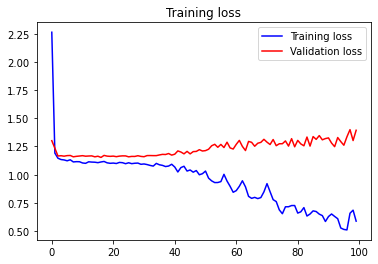

In [ ]:
#loading train/test original point cloud and train/test rotated point cloud
P_r_train = np.load('train_point_cloud.npy')
P_r_test = np.load('test_point_cloud.npy')
P_t_train = np.load('6D_rotated_train_point_cloud.npy')
P_t_test = np.load('6D_rotated_test_point_cloud.npy')

size = 3000
tr_len = 626
te_len = 100
sbst = tr_len
tot = tr_len + te_len

#original 3 x 3 matrix, from which we obtain rotor, bivector, euler, and angle axis
r = np.load('rotmatr_point_cloud.npy')
r = np.reshape(r, [tot, 3, 3])


P_r_train = np.reshape(P_r_train, [tr_len,size, 3])
P_t_train = np.reshape(P_t_train, [tr_len,size, 3])
P_r_test = np.reshape(P_r_test, [te_len,size, 3])
P_t_test = np.reshape(P_t_test, [te_len,size, 3])



#### adding noise ####
s = 5

noise = np.random.normal(0, s, P_t_train.shape)
P_t_train = P_t_train + noise
noise = np.random.normal(0, s, P_t_train.shape)
P_r_train = P_r_train + noise


noise = np.random.normal(0, s, P_t_test.shape)
P_t_test = P_t_test + noise
noise = np.random.normal(0, s, P_t_test.shape)
P_r_test = P_r_test + noise



r = np.reshape(r, [tr_len+te_len, 3* 3])
#r = np.reshape(r, [tr_len+te_len, 3, 3])


b = []
rot = []
for i in range(0,tot):
    matrix = np.reshape(r[i], [3, 3])

    #express the rotation matrix as a quaternion / euler angle / axis angle
    Q = R.from_matrix(matrix)
    #B = Q.as_euler('xyz')
    #B = Q.as_rotvec()
    Q = Q.as_quat()

    #rotor from quaternion
    Rot = Q[0] + Q[2]*e13 +Q[1]*e23 + Q[3]*e12

    #Rot = up(Q[0] + Q[2]*e13 +Q[1]*e23 + Q[3]*e12)

    #bivector as exponential
    B = -2*general_logarithm(Rot)

    #bivector as Cayley transform
    #B = (1 - Rot)/(1 + Rot)


    #CGA bivector
    '''
    rotor = []
    for j in range(0,32):
        rotor = np.append(rotor, Rot[j])
    
    rot = np.append(rot, rotor)

    B = -2*general_logarithm(Rot)
    #B = (1 - Rot)/(1+Rot)
    bi = []
    for i in range(6,16):
        bi = np.append(bi, B[i])

    b = np.append(b, bi)
    '''
    #storing the bivector
    #b = np.append(b, [B[0], B[1], B[2]]) #for euler / axis angle
    b = np.append(b, [B[6], B[7], B[10]]) #for bivector
    #b = np.append(b, [Q[0], Q[2], Q[1], Q[3]]) #for rotor / quaternion



#train-test split
b = np.reshape(b, [tr_len+te_len, 3])
b_train = b[0:tr_len, :]
b_test = b[tr_len:, :]

r_train = r[0:tr_len, :]
r_test = r[tr_len:, :]


P_r_train = np.reshape(P_r_train, [tr_len, size,3])
P_t_train = np.reshape(P_t_train, [tr_len, size,3])

tf.executing_eagerly()

#defining the deep neural network

def MLPNet():
    input = Input(shape=(size, 2*3))
    x = Conv1D(64, 1)(input)
    x = keras.layers.LeakyReLU()(x)
    x = Conv1D(128, 1)(x)
    x = keras.layers.LeakyReLU()(x)
    x = Conv1D(256, 1)(x)
    x = keras.layers.LeakyReLU()(x)
    x = Conv1D(1024, 1)(x)
    out = MaxPooling1D(size)(x)
    model = keras.Model(inputs = input, outputs = out)

    plot_model(model, show_shapes=True, show_dtype=True)

    inp1 = Input(shape=(size,2*3)) 
    #inp2 = Input(shape=(size,2*3))

    model_1 = model(inp1) 
    #model_2 = model(inp2)
    #merge_layers = concatenate([model_1, model_2])
    #distance_func = Lambda(lambda t: K.abs(t[0]-t[1]))
    #merge_layers = distance_func([model_1, model_2])
    #print(merge_layers)

    x = Dense(512)(model_1)
    x = Dropout(0.5)(x)
    x = keras.layers.LeakyReLU()(x)
    x = Dense(512)(x)
    x = Dropout(0.3)(x)
    x = keras.layers.LeakyReLU()(x)
    x = Flatten()(x)
    fc3 = Dense(3)(x)

    MLP = keras.Model(inputs=inp1, outputs=[fc3])
    plot_model(MLP, show_shapes=True, show_dtype=True)
    return MLP
    
matchnet = MLPNet()
matchnet.summary()  #Print Network Structure


nb_epoch =  100
batch_size = 32

opt = keras.optimizers.SGD(learning_rate=0.0001)

import keras.backend as K

point = tf.constant([1, 1, 1], tf.float32)

def custom_loss(y_true, y_pred):

    y_pred = tf.reshape(y_pred, [-1, 3, 3])
  
    a1 = y_pred[:,:,0]
    a2 = y_pred[:,:,1]


    b1, _ = tf.linalg.normalize(a1, ord='euclidean')
    c = tf.tensordot(b1, a2, axes=[1, 1])
    c = a2 - tf.matmul(c, b1)
    b2, _ = tf.linalg.normalize(c, ord='euclidean')

    b3 = tf.linalg.cross(b1, b2)
    y_pred_rot = tf.concat([b1, b2, b3], axis = 1)

    l2 = K.mean((y_true - y_pred_rot)**2)

    return l2


matchnet.compile(loss = 'mae', optimizer = 'adam', run_eagerly=True)

P_train = np.concatenate((P_r_train, P_t_train), axis = 2)
#P_train = P_r_train - P_t_train
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
model_train = matchnet.fit(x = P_train, y = b_train, 
                        validation_split = 0.3,
                        epochs=nb_epoch,
                        verbose=0,
                        shuffle=False,
                        batch_size=batch_size)


loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(0,np.size(loss))
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Prediction

In [ ]:
#######PREDICTION FOR ROTOR AND BIVECTOR#######
predicted = matchnet.predict(np.concatenate((P_r_test, P_t_test), axis = 2))
#predicted = matchnet.predict([P_r_test, P_t_test])

TEST = b_test
Langle = []


for i in range(0,5):
    print(predicted[i])
    print(TEST[i])
    print('----')

from math import acos

Langle = []

####BIVECTOR CASE#####
for i in range(0, te_len):
    B = predicted[i][0]*e12 + predicted[i][1]*e13 + predicted[i][2]*e23
    #print(B)
    #Cayley transform
    #Rot_pred = (1-B)/(1+B) 
    #Exponential
    Rot_pred = e**(-0.5*B)

    B = TEST[i][0]*e12 +TEST[i][1]*e13 + TEST[i][2]*e23
    #print(B)
    #Cayley transform
    #Rot_real = (1-B)/(1+B) 
    #Exponential
    Rot_real = e**(-0.5*B)

    #print(Rot_pred)
    #print(Rot_real)
    #print('---')
    
    cosine = (Rot_real*~Rot_pred)[0]
    
    if cosine > 1:
        cosine = 1
    if cosine < -1:
        cosine = -1
    Langle = np.append(Langle, acos(cosine))


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)


'''

####ROTOR CASE#####
for i in range(0,te_len):
    Rot_pred = predicted[i][0] + +predicted[i][1]*e13 + predicted[i][2]*e23 + predicted[i][3]*e12
    Rot_real = TEST[i][0] +TEST[i][1]*e13 + TEST[i][2]*e23 + TEST[i][3]*e12

    print(Rot_pred)
    print(Rot_real)
    print('---')
    cosine = (Rot_real*~Rot_pred)[0]

    if cosine > 1:
        cosine = 1
    if cosine < -1:
        cosine = -1
    Langle = np.append(Langle, acos(cosine))

print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)
'''
np.save('doublenoise5_bivector_PREDICTED.npy', predicted)
np.save('doublenoise5_b_test.npy', b_test)
#np.save('rotor_val_loss.npy', val_loss)
#np.save('rotor_geodesicloss.npy', Langle)
#np.save('rotor_PREDICTED.npy', predicted)


[-0.36207998 -0.37130827  0.28752813]
[-2.003067    0.48527818  1.62413194]
----
[-0.97909945  0.37600443  1.2259395 ]
[-0.68299844 -1.53271726  1.61633683]
----
[-0.50046957 -0.2963291   0.51958483]
[-0.46210219 -0.03721635  0.52834865]
----
[ 0.19926818 -1.2122701   0.8176114 ]
[ 0.49133943 -1.01357733  1.59537734]
----
[-0.44243708  0.23044418  1.3760169 ]
[ 1.05284425 -0.79825063 -0.18618748]
----
135.5569475370067
62.713090582699024
25.603091907895674


In [ ]:
#######PREDICTION FOR 6D##########

predicted = matchnet.predict(np.concatenate((P_r_test, P_t_test), axis = 2))
#predicted = matchnet.predict([P_r_test, P_t_test])
TEST = r_test

Langle = []

for i in range(0,int(te_len)):
    y_pred = np.reshape(predicted[i], [3, 3])
    y_real = np.reshape(r_test[i], [3, 3])
    
    a1 = y_pred[:,0]
    a2 = y_pred[:,1]

    b1 = a1 / np.linalg.norm(a1)
    b2 = a2 - np.dot(a2,b1)*b1
    b2 = b2 / np.linalg.norm(b2)

    b3 = np.cross(b1, b2)

    #y_pred_n = np.transpose([b1, b2, b3])
    y_pred_n = np.reshape([b1, b2, b3], [3,3])
    y_real = np.reshape(TEST[i], [3, 3])

    
    M = np.matmul(y_real, np.linalg.inv(y_pred_n))
    cosine = (M[0,0] + M[1,1] + M[2,2] - 1)/2

    #M = np.dot(y_real,  1/y_pred)
    #cosine = (M - 1)/2
    if cosine > 1:
        cosine = 1
    
    if cosine < -1:
        cosine = -1
    
    #if i < 4:
        #print(predicted[i])
        #print(y_pred)
        #print('---')
        #print(y_pred_n)
        #print(y_pred_n)
        #print('---')
        #print(y_real)
        #print(M)
        #print('-----------')
    
    #print(acos(cosine))
    Langle = np.append(Langle, acos(cosine))


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

#np.save('6D_geodesicloss.npy', Langle)
#np.save('6D_loss.npy', loss)
#np.save('6D_val_loss.npy', val_loss)
#np.save('doublenoise5_6D_PREDICTED.npy', predicted)

In [ ]:
#######PREDICTION FOR MATRIX, EULER, ANGLE AXIS##########

predicted = matchnet.predict(np.concatenate((P_r_test, P_t_test), axis = 2))
#predicted = matchnet.predict([P_r_test, P_t_test])
TEST = r_test

Langle = []

for i in range(0,int(te_len)):
    y_pred = np.reshape(predicted[i], [3, 3])
    y_real = np.reshape(r_test[i], [3, 3])
    '''
    y_pred = np.reshape(predicted[i], 4)
    y_real = np.reshape(b_test[i], 4)

    #y_pred = R.from_euler('xyz', y_pred)
    #y_pred = R.from_rotvec(y_pred)
    y_pred = R.from_quat(y_pred)
    y_pred = y_pred.as_matrix()

    #y_real = R.from_euler('xyz', y_real)
    #y_real = R.from_rotvec(y_real)
    y_real = R.from_quat(y_real)
    y_real = y_real.as_matrix()
    '''

    M = np.matmul(y_real, np.linalg.inv(y_pred))
    #print(M)
    cosine = (M[0,0] + M[1,1] + M[2,2] - 1)/2

    #M = np.dot(y_real,  1/y_pred)
    #cosine = (M - 1)/2
    if cosine > 1:
        cosine = 1
    
    if cosine < -1:
        cosine = -1
    
    #print(acos(cosine))
    Langle = np.append(Langle, acos(cosine))


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

#np.save('6D_geodesicloss.npy', Langle)
#np.save('6D_loss.npy', loss)
#np.save('6D_val_loss.npy', val_loss)
#np.save('6D_PREDICTED.npy', predicted)

In [ ]:
#######PREDICTION ON CGA BIVECTOR###############
predicted = matchnet.predict(np.concatenate((P_r_test, P_t_test), axis = 2))
TEST = b_test
from scipy.spatial.transform import Rotation as R
Langle = []

for i in range(0,int(te_len)):
    B = predicted[i][0]*e12 +predicted[i][1]*e13 + predicted[i][2]*e14+ predicted[i][3]*e15 +predicted[i][4]*e23 + predicted[i][5]*e24+predicted[i][6]*e25 +predicted[i][7]*e34 + predicted[i][8]*e35+predicted[i][9]*e45
    Rot_pred = e**(-B/5)

    #B = predicted[i][0]*e12 +predicted[i][1]*e13 +predicted[i][4]*e23
    #Rot_pred = (1-B)/(1+B)       
    
    #print(Rot_pred)
    B = TEST[i][0]*e12 +TEST[i][1]*e13 + TEST[i][2]*e14+ TEST[i][3]*e15+TEST[i][4]*e23 +TEST[i][5]*e24 + TEST[i][6]*e25+ TEST[i][7]*e34+TEST[i][8]*e35 +TEST[i][9]*e45
    Rot_real = e**(-B/5)
    #Rot_real = (1-B)/(1+B) 

    

    '''
    y_pred = [Rot_pred[0], Rot_pred[6], Rot_pred[7], Rot_pred[10]]
    y_pred = R.from_quat(y_pred)
    y_pred = y_pred.as_matrix()

    #y_real = R.from_euler('xyz', y_real)
    y_real = [Rot_real[0], Rot_real[6], Rot_real[7], Rot_real[10]]
    y_real = R.from_quat(y_real)
    y_real = y_real.as_matrix()
    
    M = np.matmul(y_real, np.linalg.inv(y_pred))
    cosine = (M[0,0] + M[1,1] + M[2,2] - 1)/2
    '''

    cosine = (Rot_real*~Rot_pred)[0]
    
    #M = np.dot(y_real,  1/y_pred)
    #cosine = (M - 1)/2
    if cosine > 1:
        cosine = 1
    
    if cosine < -1:
        cosine = -1
    
    #print(acos(cosine))
    Langle = np.append(Langle, acos(cosine))

    #print(Rot_real)

    #print(Rot_real*~Rot_pred)
    '''
    cosine = (Rot_real*~Rot_pred)[0]
    #print(cosine)
    print('-----------------')
    if cosine > 1:
        cosine = 1
    Langle = np.append(Langle, acos(cosine))
    '''

print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

#np.save('airplane_3000_CGAbiv_loss.npy', loss)
#np.save('airplane_3000_CGAbiv_val_loss.npy', val_loss)
#np.save('airplane_3000_CGAbiv_PREDICTED.npy', predicted)